# League of Legends Early Objectives

## Imports

In [1]:
%matplotlib inline

from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
from json import load
from os import listdir, remove
from os.path import expanduser, isfile, join
from time import sleep


import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import clear_output, display

## Define Features

In [2]:
def _extract_indicator_from_teams(key: str, match_details: dict) -> int:
    indicator = 0
    for team in match_details['teams']:
        if team['teamId'] == 100:
            indicator -= team[key]
        else:
            indicator += team[key]
    return indicator

def _extract_participant_stat(aggregator: callable, key: str, match_details: dict) -> int:
    blue = aggregator(
        participant['stats'][key] if key in participant['stats'] else 0
        for participant in match_details['participants']
        if participant['teamId'] == 100)

    red = aggregator(
        participant['stats'][key] if key in participant['stats'] else 0
        for participant in match_details['participants']
        if participant['teamId'] == 200)
    
    return red-blue

def _extract_participant_timeline_key(team_id: int, lane: str, key: str, frame: str, match_details: dict):
    '''
    - team_id (int): Possible values are 100 (blue)
        and 200 (red).

    - lane (str): Possible values are 'MIDDLE', 'TOP',
        'JUNGLE' and 'BOTTOM'.

    - key (str): Possbile values are 'goldPerMinDeltas',
        'creepsPerMinDeltas', 'xpPerMinDeltas' and
        'damageTakenPerMinDeltas'

    - frame (str): Possible values are '0-10', '10-20',
        '20-30' and '30-end'.

    - match_details (dict): whole dictionary of parse
        match json.
    '''
    metric = 0.0  # sum because two players are bottom

    for participant in match_details['participants']:
        is_lane = participant['timeline']['lane'] == lane
        is_team = participant['teamId'] == team_id
        
        if is_lane and is_team:
            try:
                metric += participant['timeline'][key][frame]
            except KeyError:
                return np.nan
            
    return metric

def extract_red_win(match_details: dict) -> bool:
    team = match_details['teams'][0]
    
    if team['teamId'] == 100:  # blue
        if team['win'] == 'Win':
            return False
        else:
            return True
    else:  # red
        if team['win'] == 'Win':
            return True
        else:
            return False

team_to_text = {100: 'blue', 200: 'red'}
        
def generate_participant_timeline_extractors(team_ids: (int,), lanes: (str,), keys: (str,), frames: (str,)):
    for team_id in (100, 200):
        for lane in ('BOTTOM', 'MIDDLE', 'TOP', 'JUNGLE'):
            for key in ('goldPerMinDeltas', 'creepsPerMinDeltas', 'xpPerMinDeltas', 'damageTakenPerMinDeltas'):
                for frame in ('0-10',):
                    yield (
                        f"{key}{team_to_text[team_id].title()}{lane.title()}{frame.split('-')[-1]}",
                        'f4',
                        partial(_extract_participant_timeline_key, team_id, lane, key, frame)
                    )
        
features = (
    ('redWin', 'i1', extract_red_win),

    ('firstDragon', 'f4', partial(_extract_indicator_from_teams, 'firstDragon')),
    ('firstRiftHerald', 'f4', partial(_extract_indicator_from_teams, 'firstRiftHerald')),
    
    ('firstBlood', 'f4', partial(_extract_indicator_from_teams, 'firstBlood')),
    ('anyFirstBloodAssist', 'f4', partial(_extract_participant_stat, any, 'firstBloodAssist')),
    ('sumFirstBloodAssist', 'f4', partial(_extract_participant_stat, sum, 'firstBloodAssist')),

    ('firstTower', 'f4', partial(_extract_indicator_from_teams, 'firstTower')),
    ('anyFirstTowerAssist', 'f4', partial(_extract_participant_stat, any, 'firstTowerAssist')),
    ('sumFirstTowerAssist', 'f4', partial(_extract_participant_stat, sum, 'firstTowerAssist'))
)+tuple(
    extractor for extractor in
    generate_participant_timeline_extractors(
        (100, 200),
        ('BOTTOM', 'MIDDLE', 'TOP', 'JUNGLE'),
        ('goldPerMinDeltas', 'creepsPerMinDeltas', 'xpPerMinDeltas', 'damageTakenPerMinDeltas'),
        ('0-10',)
    )
)

## Loading Data

The data is in a folder with one file per match. The files are JSON encoded and named `{matchID}.json`.

In [3]:
base_path = join(expanduser('~'), 'Downloads', 'lol_matches')

filelist = listdir(base_path)

data = np.zeros(len(filelist), dtype=[(f, t) for f, t, _ in features])

type_to_default = {'i1': -128, 'f4': np.nan}
for f, t, _ in features:
    data[f] = type_to_default[t]

print(f"loading max. {len(filelist)} files")

def load_and_parse_match_details(file_i: int, base_path: str, file_name: str):
    file_path = join(base_path, file_name)

    if isfile(file_path):
        with open(file_path, 'r') as match_file:
            match_details = load(match_file)
            
        if not match_details['queueId'] in (420, 440):
            remove(file_path)
        else:
            for feature, _, extractor in features:
                try:
                    data[feature][file_i] = extractor(match_details)
                except Exception as exception:
                    print(f"error parsing feature {feature} for {file_name}")
                    raise
                
    return file_i

max_file_done = 0

with ThreadPoolExecutor(max_workers=4) as executor:
    
    print(f"using {executor._max_workers} threads")

    futures = tuple(
        executor.submit(load_and_parse_match_details, file_i, base_path, file_name)
        for file_i, file_name in enumerate(filelist)
        if file_name.endswith('.json')
    )
    
    print(f"submitted all {len(futures)} to the executor")
    
    for future in as_completed(futures):
        try:
            file_i = future.result()
        except Exception as exception:
            executor.shutdown()
            print(f"error parsing files - {exception}")
            raise
        else:
            max_file_done = max(max_file_done, file_i)
            if file_i%1000 == 0 or max_file_done+1==len(filelist):
                clear_output(wait=True)
                display(f"{100.0*float(max_file_done+1)/float(len(filelist)):>5.1f}%")

'100.0%'

## Cleanup

Remove matches that have any NaN values.

In [4]:
print(len(data))

missing_mask = np.zeros(len(data), dtype=np.bool)

for f, _, _ in features:
    missing_mask |= np.isnan(data[f])
    
data = data[~missing_mask].copy()

print(len(data))

111936
111869


Remove matches without first blood or first tower. These presumably were not played to the end.

In [5]:
print(len(data))

data = data[:][((data['firstBlood'] != 0) | (data['firstTower'] != 0))].copy()

print(len(data))

111869
111091


Drop any columns that only have one value. They provide no information at all.

In [6]:
print(len(features))

keep_columns = []
for f, _, _ in features:
    if f not in data.dtype.names:
        continue
    if not (data[f] == data[f][0]).all():
        keep_columns.append(f)
    else:
        print(f"dropping {f}")

41
dropping anyFirstBloodAssist
dropping sumFirstBloodAssist


In [7]:
data = data[keep_columns].copy()

In [8]:
features = tuple(f for f in features if f[0] in keep_columns)

print(len(features))

39


Scale the prdictors to have an expected value of 0 and standard deviation of 1.

In [9]:
for f, _, _ in features:
    if f == 'redWin':
        continue
    data[f] = (data[f]-np.mean(data[f]))/np.std(data[f])
    
    print(f"{f:>35}: mean={np.mean(data[f]):>5.2f}, std={np.std(data[f]):>5.2f}")

                        firstDragon: mean= 0.00, std= 1.00
                    firstRiftHerald: mean= 0.00, std= 1.00
                         firstBlood: mean=-0.00, std= 1.00
                         firstTower: mean= 0.00, std= 1.00
                anyFirstTowerAssist: mean=-0.00, std= 1.00
                sumFirstTowerAssist: mean=-0.00, std= 1.00
       goldPerMinDeltasBlueBottom10: mean=-0.00, std= 1.00
     creepsPerMinDeltasBlueBottom10: mean=-0.00, std= 1.00
         xpPerMinDeltasBlueBottom10: mean= 0.00, std= 1.00
damageTakenPerMinDeltasBlueBottom10: mean=-0.00, std= 1.00
       goldPerMinDeltasBlueMiddle10: mean=-0.00, std= 1.00
     creepsPerMinDeltasBlueMiddle10: mean=-0.00, std= 1.00
         xpPerMinDeltasBlueMiddle10: mean= 0.00, std= 1.00
damageTakenPerMinDeltasBlueMiddle10: mean=-0.00, std= 1.00
          goldPerMinDeltasBlueTop10: mean=-0.00, std= 1.00
        creepsPerMinDeltasBlueTop10: mean=-0.00, std= 1.00
            xpPerMinDeltasBlueTop10: mean= 0.00, std= 1.

## Exploring the Data

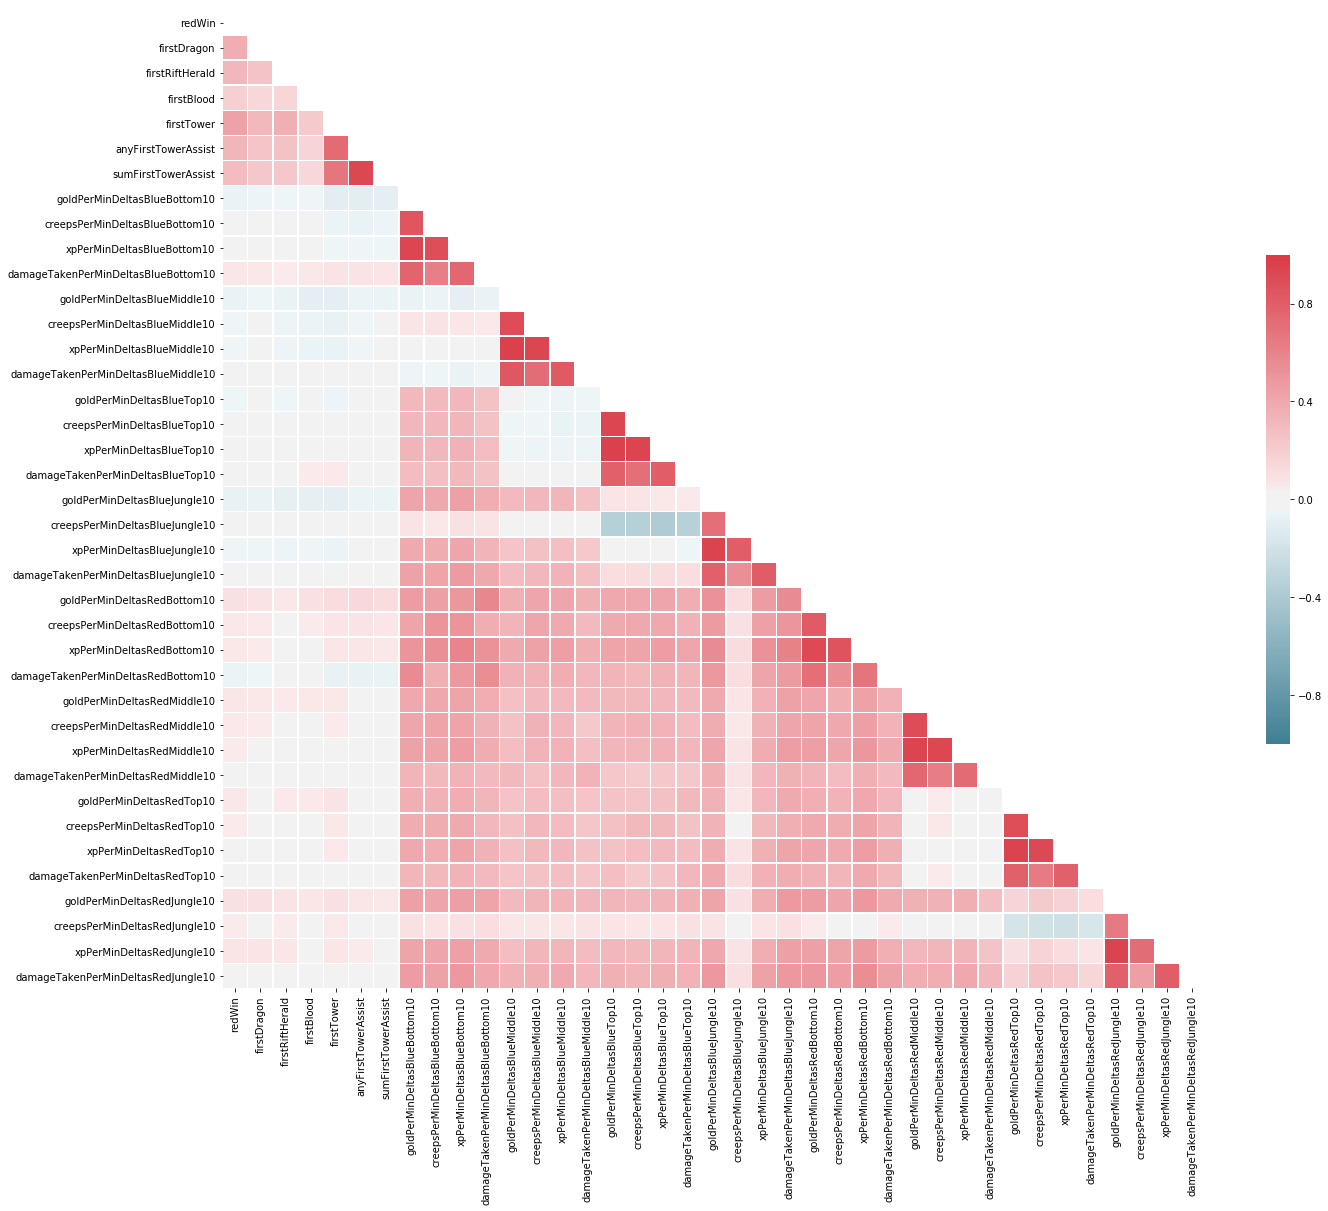

In [10]:
# Compute the correlation matrix
corr = np.zeros((len(features), len(features)), dtype='float32')

for f1_i, (f1, _, _) in enumerate(features):
    for f2_i, (f2, _, _) in enumerate(features):
        corr[f1_i, f2_i] = np.corrcoef(data[f1], data[f2])[0, 1]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sb.heatmap(
    corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
    linewidths=.5, cbar_kws={"shrink": .5},
    ax=ax, # annot=True,
    xticklabels=tuple(f for f, _, _ in features),
    yticklabels=tuple(f for f, _, _ in features))

## Logistic Model

In [ ]:
# data['sumFirstTowerAssist'] = (((data['sumFirstTowerAssist']*data['anyFirstTowerAssist'])+1)*data['anyFirstTowerAssist'])
# data['sumFirstTowerAssist'] = (1.5 / (1 + np.exp(-data['sumFirstTowerAssist'])))-0.5

In [11]:
model_equation = f"redWin ~ {' + '.join(f for f, _, _ in features if f != 'redWin')}"
indent = ' '.join('' for _ in range(len(model_equation.split('~')[0])+1))
print(model_equation.replace('+', f"\n{indent}+"), end='\n\n')

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(model_equation, data, family=pm.glm.families.Binomial())
    print(logistic_model.check_test_point())
    trace_logistic_model = pm.sample(2000, chains=None, tune=1000)

redWin ~ firstDragon 
       + firstRiftHerald 
       + firstBlood 
       + firstTower 
       + anyFirstTowerAssist 
       + sumFirstTowerAssist 
       + goldPerMinDeltasBlueBottom10 
       + creepsPerMinDeltasBlueBottom10 
       + xpPerMinDeltasBlueBottom10 
       + damageTakenPerMinDeltasBlueBottom10 
       + goldPerMinDeltasBlueMiddle10 
       + creepsPerMinDeltasBlueMiddle10 
       + xpPerMinDeltasBlueMiddle10 
       + damageTakenPerMinDeltasBlueMiddle10 
       + goldPerMinDeltasBlueTop10 
       + creepsPerMinDeltasBlueTop10 
       + xpPerMinDeltasBlueTop10 
       + damageTakenPerMinDeltasBlueTop10 
       + goldPerMinDeltasBlueJungle10 
       + creepsPerMinDeltasBlueJungle10 
       + xpPerMinDeltasBlueJungle10 
       + damageTakenPerMinDeltasBlueJungle10 
       + goldPerMinDeltasRedBottom10 
       + creepsPerMinDeltasRedBottom10 
       + xpPerMinDeltasRedBottom10 
       + damageTakenPerMinDeltasRedBottom10 
       + goldPerMinDeltasRedMiddle10 
       + cree

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [damageTakenPerMinDeltasRedJungle10, xpPerMinDeltasRedJungle10, creepsPerMinDeltasRedJungle10, goldPerMinDeltasRedJungle10, damageTakenPerMinDeltasRedTop10, xpPerMinDeltasRedTop10, creepsPerMinDeltasRedTop10, goldPerMinDeltasRedTop10, damageTakenPerMinDeltasRedMiddle10, xpPerMinDeltasRedMiddle10, creepsPerMinDeltasRedMiddle10, goldPerMinDeltasRedMiddle10, damageTakenPerMinDeltasRedBottom10, xpPerMinDeltasRedBottom10, creepsPerMinDeltasRedBottom10, goldPerMinDeltasRedBottom10, damageTakenPerMinDeltasBlueJungle10, xpPerMinDeltasBlueJungle10, creepsPerMinDeltasBlueJungle10, goldPerMinDeltasBlueJungle10, damageTakenPerMinDeltasBlueTop10, xpPerMinDeltasBlueTop10, creepsPerMinDeltasBlueTop10, goldPerMinDeltasBlueTop10, damageTakenPerMinDeltasBlueMiddle10, xpPerMinDeltasBlueMiddle10, creepsPerMinDeltasBlueMiddle10, goldPerMinDeltasBlueMiddle10, damageTakenPerMinDeltasBl

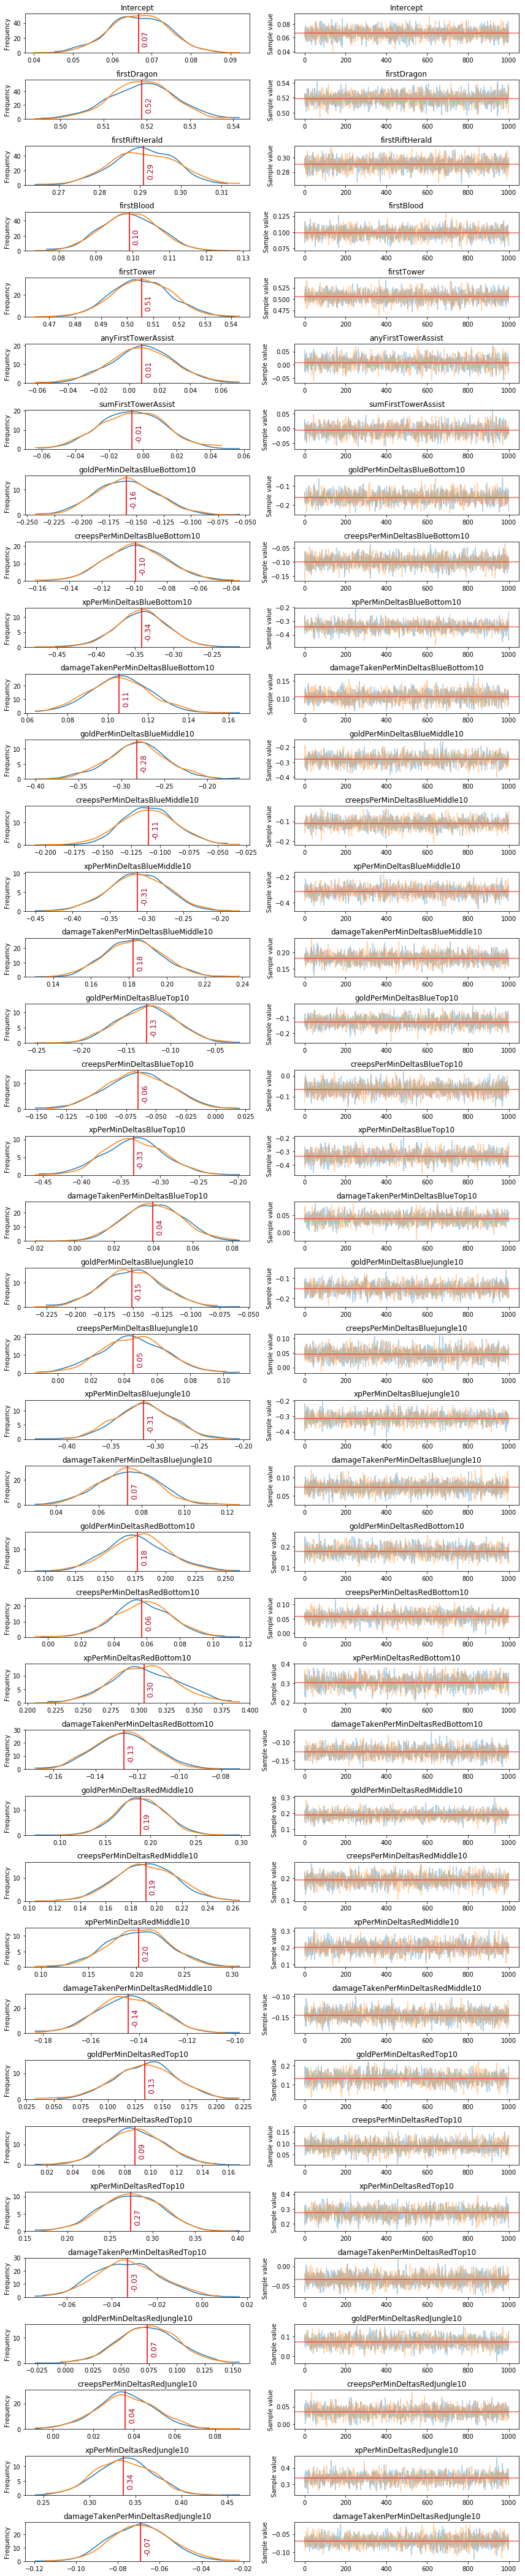

In [12]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

plot_traces(trace_logistic_model, retain=1000)

In [24]:
for mean, name in sorted(zip(pm.summary(trace_logistic_model[-1000:])['mean'], trace_logistic_model.varnames), reverse=True):
    print(f"{name:>35}: {mean:5.2f}")

                        firstDragon:  0.52
                         firstTower:  0.51
          xpPerMinDeltasRedJungle10:  0.34
          xpPerMinDeltasRedBottom10:  0.30
                    firstRiftHerald:  0.29
             xpPerMinDeltasRedTop10:  0.27
          xpPerMinDeltasRedMiddle10:  0.20
      creepsPerMinDeltasRedMiddle10:  0.19
        goldPerMinDeltasRedMiddle10:  0.19
damageTakenPerMinDeltasBlueMiddle10:  0.18
        goldPerMinDeltasRedBottom10:  0.18
           goldPerMinDeltasRedTop10:  0.13
damageTakenPerMinDeltasBlueBottom10:  0.11
                         firstBlood:  0.10
         creepsPerMinDeltasRedTop10:  0.09
        goldPerMinDeltasRedJungle10:  0.07
damageTakenPerMinDeltasBlueJungle10:  0.07
                          Intercept:  0.07
      creepsPerMinDeltasRedBottom10:  0.06
     creepsPerMinDeltasBlueJungle10:  0.05
   damageTakenPerMinDeltasBlueTop10:  0.04
      creepsPerMinDeltasRedJungle10:  0.04
                anyFirstTowerAssist:  0.01
           

In [38]:
def generate_blue_red_factor_differences(trace, retain=1000):
    factors = {name: mean for mean, name in zip(pm.summary(trace_logistic_model[-1000:])['mean'], trace_logistic_model.varnames)}
    for key in ('goldPerMinDeltas', 'creepsPerMinDeltas', 'xpPerMinDeltas', 'damageTakenPerMinDeltas'):
        for lane in ('BOTTOM', 'MIDDLE', 'TOP', 'JUNGLE'):
            k1 = f"{key}Red{lane.title()}10"
            k2 = f"{key}Blue{lane.title()}10"
            yield factors[k1]+factors[k2], f"{key}{lane.title()}10"

In [39]:
for m, n in sorted(generate_blue_red_factor_differences(trace_logistic_model), reverse=True):
    print(f"{n:>35}: {m:5.2f}")

         creepsPerMinDeltasJungle10:  0.08
         creepsPerMinDeltasMiddle10:  0.08
    damageTakenPerMinDeltasMiddle10:  0.04
             xpPerMinDeltasJungle10:  0.02
            creepsPerMinDeltasTop10:  0.02
           goldPerMinDeltasBottom10:  0.02
              goldPerMinDeltasTop10:  0.01
       damageTakenPerMinDeltasTop10:  0.01
    damageTakenPerMinDeltasJungle10:  0.00
    damageTakenPerMinDeltasBottom10: -0.02
             xpPerMinDeltasBottom10: -0.04
         creepsPerMinDeltasBottom10: -0.04
                xpPerMinDeltasTop10: -0.06
           goldPerMinDeltasJungle10: -0.08
           goldPerMinDeltasMiddle10: -0.09
             xpPerMinDeltasMiddle10: -0.11
